In [1]:
from pgvector.psycopg import register_vector
import psycopg


In [2]:
conn = psycopg.connect(dbname='pokemon_db', autocommit=True)

register_vector(conn)

In [3]:
conn.execute('SELECT * from pokemons LIMIT 5;').fetchall()

[(53120,
  'http://images.cocodataset.org/val2014/COCO_val2014_000000053120.jpg',
  'Several horses with riders crossing a body of water.',
  'A group of people is riding horses along a sandy beach near a body of water. The horses are walking in the shallow water, and the riders are wearing blue and red clothing. The beach is surrounded by trees, and there is a wooden post visible in the foreground.',
  './saved_images_coco_30k/53120_53120.jpg',
  array([-1.19251013e-02, -1.42739182e-02,  2.58338619e-02,  2.77637746e-02,
          8.01595673e-02,  7.76806474e-03, -1.77450012e-02, -2.83768177e-02,
          2.76748948e-02,  4.49392609e-02,  5.27689978e-02, -5.89205213e-02,
         -4.54307348e-03,  2.15000510e-02, -2.99798865e-02, -7.23779248e-03,
         -1.87725909e-02,  5.08540832e-02,  5.13329729e-02,  3.54480483e-02,
         -8.78155902e-02, -1.70766152e-02, -4.36501652e-02,  1.33360941e-02,
          1.40420748e-02,  1.18245780e-02, -3.87900285e-02, -4.38412428e-02,
          1

In [17]:
sql = """
WITH semantic_search AS (
    SELECT image_id, image_filepath, RANK () OVER (ORDER BY img_emb <=> %(embedding)s) AS rank
    FROM pokemons
    ORDER BY img_emb <=> %(embedding)s
    LIMIT 20
),
keyword_search AS (
    SELECT image_id, image_filepath, RANK () OVER (ORDER BY ts_rank_cd(to_tsvector('english', caption), query) DESC)
    FROM pokemons, plainto_tsquery('english', %(query)s) query
    WHERE to_tsvector('english', caption) @@ query
    ORDER BY ts_rank_cd(to_tsvector('english', caption), query) DESC
    LIMIT 20
)
SELECT
    COALESCE(semantic_search.image_id, keyword_search.image_id) AS id,
    COALESCE(semantic_search.image_filepath, keyword_search.image_filepath) AS image_filepath,
    COALESCE(1.0 / (%(k)s + semantic_search.rank), 0.0) +
    COALESCE(1.0 / (%(k)s + keyword_search.rank), 0.0) AS score
FROM semantic_search
FULL OUTER JOIN keyword_search ON semantic_search.image_id = keyword_search.image_id
ORDER BY score DESC
LIMIT 10
"""

In [18]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# if you have CUDA or MPS, set it to the active device like this
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

query = "a dog in the snow"

# create transformer-readable tokens
inputs = tokenizer(query, return_tensors="pt").to(device)

# use CLIP to encode tokens into a meaningful embedding
text_emb = model.get_text_features(**inputs)
text_emb = text_emb.cpu().detach().numpy()
text_emb = text_emb.flatten()


In [19]:
text_emb.shape

(512,)

In [20]:
k = 60
results = conn.execute(sql, {'query': query, 'embedding': text_emb, 'k': k}).fetchall()
for row in results:
    print('document:', row[0], 'RRF score:', row[1])

document: 512836 RRF score: ./saved_images_coco_30k/512836_512836.jpg
document: 457575 RRF score: ./saved_images_coco_30k/457575_457575.jpg
document: 379077 RRF score: ./saved_images_coco_30k/379077_379077.jpg
document: 102598 RRF score: ./saved_images_coco_30k/102598_102598.jpg
document: 528488 RRF score: ./saved_images_coco_30k/528488_528488.jpg
document: 106900 RRF score: ./saved_images_coco_30k/106900_106900.jpg
document: 351287 RRF score: ./saved_images_coco_30k/351287_351287.jpg
document: 165035 RRF score: ./saved_images_coco_30k/165035_165035.jpg
document: 434968 RRF score: ./saved_images_coco_30k/434968_434968.jpg
document: 270785 RRF score: ./saved_images_coco_30k/270785_270785.jpg


In [21]:
results

[(512836,
  './saved_images_coco_30k/512836_512836.jpg',
  Decimal('0.03252247488101533580')),
 (457575,
  './saved_images_coco_30k/457575_457575.jpg',
  Decimal('0.03151364764267990075')),
 (379077,
  './saved_images_coco_30k/379077_379077.jpg',
  Decimal('0.03102453102453102454')),
 (102598,
  './saved_images_coco_30k/102598_102598.jpg',
  Decimal('0.03041474654377880184')),
 (528488,
  './saved_images_coco_30k/528488_528488.jpg',
  Decimal('0.03030303030303030304')),
 (106900,
  './saved_images_coco_30k/106900_106900.jpg',
  Decimal('0.02946236559139784946')),
 (351287,
  './saved_images_coco_30k/351287_351287.jpg',
  Decimal('0.01639344262295081967')),
 (165035,
  './saved_images_coco_30k/165035_165035.jpg',
  Decimal('0.01612903225806451613')),
 (434968,
  './saved_images_coco_30k/434968_434968.jpg',
  Decimal('0.01562500000000000000')),
 (270785,
  './saved_images_coco_30k/270785_270785.jpg',
  Decimal('0.01515151515151515152'))]

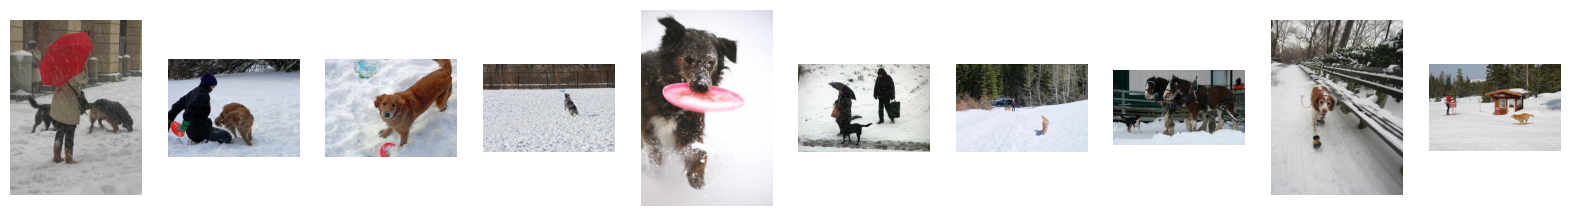

In [23]:
# plot results
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

fig, axs = plt.subplots(1, 10, figsize=(20, 20))
for i, row in enumerate(results):
    image_filepath = row[1]
    img = mpimg.imread(image_filepath)
    axs[i].imshow(img)
    axs[i].axis('off')